In [1]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[1]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

# set font size 8
plt.rcParams.update({'font.size': 8})

In [15]:
# Fetch all P4P6 data from the database
rg_ids = [123, 124]  # P4P6 rg_ids

query = """
SELECT *
FROM probe_tc_fits_view
WHERE fit_kind = 'round3_constrained'
  AND rg_id IN ({})
  AND rt_protocol = 'MRT'
ORDER BY rg_id
""".format(",".join(["?"] * len(rg_ids)))

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row
df = pd.read_sql_query(query, conn, params=rg_ids)
conn.close()

In [17]:
def calc_dG(logkobs, logkadd):
    """Calculate dG from logkobs and logkadd."""
    R = (sc.R / sc.calorie / 1000)  # kcal/(mol*K)
    T = 298.15  # K
    
    logKKp1 = logkobs - logkadd
    KKp1 = np.exp(logKKp1) # K / (K+1)
    K = KKp1 / (1 - KKp1)
    dG = -R * T * np.log(K)
    return dG

# (Strategy 3) Use max log_kobs as log_kadd for each nt_base and save in dict
max_logkobs = {}
for base in df['nt_base'].unique():
    df_base = df[df['nt_base'] == base]
    max_logkobs[base] = df_base['log_kobs'].max()

# calculate dG using base-specific max log_kobs
df['dG'] = df.apply(lambda row: calc_dG(row['log_kobs'], max_logkobs[row['nt_base']]), axis=1)

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_61710/2383672572.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  K = KKp1 / (1 - KKp1)


In [25]:
df_nomg = df[df['buffer_id'] == 2]
df_mg = df[df['buffer_id'] == 3]
df_merged = pd.merge(df_nomg[['nt_site', 'nt_base', 'log_kobs', 'log_kobs_err', 'dG', 'r2']],
                     df_mg[['nt_site', 'log_kobs', 'log_kobs_err', 'dG', 'r2']],
                     on=['nt_site'],
                     suffixes=('_nomg', '_mg'))

# filter to A and C only
df_merged_AC = df_merged[df_merged['nt_base'].isin(['A', 'C'])]

df_r2_filter = df_merged_AC.copy()

# filter to R2 > 0.5
df_merged_AC = df_merged_AC[(df_merged_AC['r2_nomg'] > 0.5) & (df_merged_AC['r2_mg'] > 0.5)]

# Merge with annotations
canonical_annots = pd.read_csv('p4p6_canonical_annots.csv')
df_merged_AC = pd.merge(df_merged_AC, canonical_annots, on=['nt_site', 'nt_base'], how='left')

In [26]:
df_r2_filter

,nt_site,nt_base,log_kobs_nomg,log_kobs_err_nomg,dG_nomg,r2_nomg,log_kobs_mg,log_kobs_err_mg,dG_mg,r2_mg
2,104,A,-3.775280,0.039808,0.411026,0.981779,-3.795475,0.071300,0.428881,0.975766
3,105,A,-4.047125,0.045539,0.638676,0.976153,-4.165104,0.077981,0.730600,0.971924
8,109,C,-4.365995,0.035195,0.707925,0.985545,-4.499681,0.083820,0.809164,0.966432
15,113,A,-4.182189,0.028209,0.743640,0.990689,-4.636739,0.095737,1.071636,0.956610
16,114,A,-3.406555,0.027499,0.043210,0.991309,-3.458740,0.033007,0.101494,0.994756
...,...,...,...,...,...,...,...,...,...,...
203,262,A,-4.551276,0.056110,1.012275,0.963976,-4.814791,0.059075,1.192757,0.982990
204,263,C,-6.721343,0.215547,2.246926,0.642335,-6.297629,0.260076,1.988792,0.747605
205,264,C,-7.503658,0.360410,2.717640,0.390958,-7.729585,0.572844,2.852717,0.378754
206,265,A,-6.427110,0.171735,2.208223,0.738889,-6.461498,0.181311,2.229079,0.859019


/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 39.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


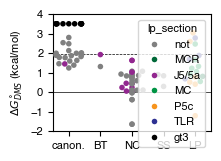

In [19]:
# melt dG_nomg and dG_mg into dG and new column "buffer" 
df_melted = pd.melt(df_merged_AC,
                       id_vars=['nt_site', 'nt_base', 'canonical', 'lp_section'],
                       value_vars=['dG_nomg', 'dG_mg'],
                       var_name='buffer',
                       value_name='dG')

# Mg swarm plot
df_merged_mg = df_melted[df_melted['buffer'] == 'dG_mg']
df_merged_mg = df_merged_mg[df_merged_mg['nt_site'] < 255]


# append 12 data points at dG = 3.5 exactly to df_merged_mg, nt_site = 0, nt_base = C, canonical = 1.0, lp_section = 'gt3', buffer = dG_mg
for i in range(12):
    new_row = {
        'nt_site': 0,
        'nt_base': 'C',
        'dG': 3.5,
        'canonical': 1.0,
        'lp_section': 'gt3',
        'buffer': 'dG_mg'
    }
    df_merged_mg = pd.concat([df_merged_mg, pd.DataFrame([new_row])], ignore_index=True)

# rename 1.0: WW, 2.0: BT, 3: ncWW, 4: NC, 5: SS, 6: LP
df_merged_mg['canonical'] = df_merged_mg['canonical'].replace({
    1.0: 'canon.',
    2.0: 'BT',
    3.0: 'NC',
    4.0: 'NC',
    5.0: 'SS',
    6.0: 'LP',
})

# set lp_section values to colors: {'not': 'gray', 'MC': 009444, 'MCR': 006838, 'TLR':2e3192, 'TL': 1c75bc, 'P5c': f7941d, "J5/5a": 92278f
lp_section_colors = {
    'not': 'gray',
    'MC': '#009444',
    'MCR': '#006838',
    'TLR': '#2e3192',
    'TL': '#1c75bc',
    'P5c': '#f7941d',
    'J5/5a': '#92278f',
    'gt3': 'black'
}

# Mg swarm plot
fig, ax = plt.subplots(figsize=(2.25, 1.65))
sns.swarmplot(data=df_merged_mg, x='canonical', y='dG', order=['canon.', 'BT', 'NC', 'NC', 'SS', 'LP'], 
              hue = 'lp_section', size = 4, ax = ax, palette=lp_section_colors)

# horizontal line at 1.95 and 0
ax.axhline(1.95, color='black', linestyle='--', linewidth=0.5)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G^{\circ}_{DMS}$ (kcal/mol)')
ax.set_ylim(-2, 4)
ax.yaxis.set_ticks(np.arange(-2, 5, 1))

plt.tight_layout()
plt.savefig('p4p6_dG_swarmplots.pdf')

In [20]:
ddG_merged = df_merged_AC.copy()
ddG_merged['ddG'] = df_merged_AC['dG_mg'] - df_merged_AC['dG_nomg']

/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


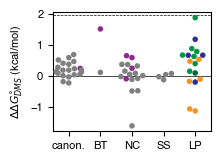

In [21]:
# rename 1.0: WW, 2.0: BT, 3: ncWW, 4: NC, 5: SS, 6: LP
ddG_merged['canonical'] = ddG_merged['canonical'].replace({
    1.0: 'canon.',
    2.0: 'BT',
    3.0: 'NC',
    4.0: 'NC',
    5.0: 'SS',
    6.0: 'LP',
})

# set lp_section values to colors: {'not': 'gray', 'MC': 009444, 'MCR': 006838, 'TLR':2e3192, 'TL': 1c75bc, 'P5c': f7941d, "J5/5a": 92278f
lp_section_colors = {
    'not': 'gray',
    'MC': '#009444',
    'MCR': '#006838',
    'TLR': '#2e3192',
    'TL': '#1c75bc',
    'P5c': '#f7941d',
    'J5/5a': '#92278f'
}

fig, ax = plt.subplots(figsize=(2.25, 1.65))
sns.swarmplot(data = ddG_merged, x='canonical', y='ddG', order=['canon.', 'BT', 'NC', 'SS', 'LP'], 
              hue = 'lp_section', palette = lp_section_colors, size = 4, ax = ax)
# remove x label
ax.set_xlabel('')
# set y label
ax.set_ylabel(r'$\Delta\Delta G^{\circ}_{DMS}$ (kcal/mol)')

# horizontal line at 0
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

# horizontal line at 1.95
ax.axhline(1.95, color='black', linestyle='--', linewidth=0.5)

# no legend
ax.legend_.remove()

plt.tight_layout()
plt.savefig('p4p6_ddG_swarmplots.pdf')

In [ ]:
# Calculations
# ddG filter to canonical == 1
ddG_merged[ddG_merged['canonical'] == 1]['ddG']
ddG_merged[ddG_merged['canonical'] == 1]['ddG'].sum()
# wilcoxon signed-rank test on ddG_merged[ddG_merged['canonical'] == 1]['ddG']
stats.wilcoxon(ddG_merged[ddG_merged['canonical'] == 1]['ddG'])

WilcoxonResult(statistic=22.0, pvalue=0.0005102157592773438)

In [ ]:
# ddG drop inf
ddG_merged['ddG'].replace([np.inf, -np.inf], np.nan).dropna().sum()

In [ ]:
# filter from 128 to 194
ddG_merged_P5abc = ddG_merged[(ddG_merged['nt_site'] >= 165) & (ddG_merged['nt_site'] <= 178)]
ddG_merged_P5abc['ddG'].sum()